# Commons

In [181]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tokenize_month_info(input='1949-01'):
    year, month = input.split('-')
    diff = (int(year) - 1949)*12 + int(month)
    return torch.tensor(diff).to(torch.float32)

In [3]:
class AirlinePassengersDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
        self.data = pd.read_csv(URL, index_col=False)
        self.scaler = MinMaxScaler()
        passengers_frame = self.data.Passengers.to_frame()
        self.scaler.fit(passengers_frame)
        scaled_passengers = self.scaler.transform(passengers_frame)
        self.passengers = scaled_passengers
        self.transform = transform

    
    def __getitem__(self, index):
        month, passenger = tokenize_month_info(self.data.Month[index]), torch.tensor(self.passengers[index]).to(torch.float32)
        return (month, passenger)
    
    def __len__(self):
        return len(self.data)


In [4]:
dataset = AirlinePassengersDataset()
split = int(len(dataset) * 0.9)
train_data, test_data = Subset(dataset, list(range(0, split))), Subset(dataset, list(range(split, len(dataset))))
loader = DataLoader(train_data, batch_size=12, shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(dataset)-split, shuffle=False)

In [5]:
print(len(loader))
for word in loader:
    print(torch.concat((word[1][0],word[1][0])))
    # print(word)
    break

11
tensor([0.0154, 0.0154])


<img src="../images/LSTM_figure4_v3a.png" style="width:500;height:400px;">

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$

$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$ 

$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$

$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$ 

$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

# Basic LSTM Cell

In [27]:
class LSTMCell(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        combined_size = input_size + hidden_size
        # forget gate
        self.forget = nn.Linear(combined_size, hidden_size, bias=True)
        # update gate
        self.update = nn.Linear(combined_size, hidden_size, bias=True)
        # tanh
        self.candidate = nn.Linear(combined_size, hidden_size, bias=True)
        # output gate
        self.output = nn.Linear(combined_size, hidden_size, bias=True)

        # final fc
        self.final = nn.Linear(hidden_size, input_size, bias=True)


    def forward(self, x, prev_a, prev_c): # hidden state and long-term memory
        # print("x, prev_a, prev_c", x, prev_a, prev_c)
        input_vector = torch.concat((x, prev_a))
        # print("input_vector", input_vector)
        forget = torch.sigmoid(self.forget(input_vector))
        # print("forget", forget)
        update = torch.sigmoid(self.update(input_vector))
        # print("update", update)
        candidate = torch.tanh(self.candidate(input_vector))
        # print("candidate", candidate)
        output = torch.sigmoid(self.output(input_vector))

        # print("output", output)
        c = (forget * prev_c) + (update * candidate)
        # print("c", c)

        a = output * torch.tanh(c)
        # print("a", a)

        x = self.final(a)
        # print("x", x)

        return x, a, c


# Non Connected LSTM with no depth

In [26]:
class LSTM(nn.Module):
    def __init__(self, cells=12, input_size=1, hidden_size=64):
        super().__init__()
        self.cells = nn.Sequential(*(LSTMCell(input_size, hidden_size) for _ in range(cells)))
        # final fc
        # self.final = nn.Linear(hidden_size, input_size, bias=True)


    def forward(self, seq, prev_a, prev_c): # hidden state and long-term memory
        output = []
        for c in range(len(seq)):
            x, prev_a, prev_c = self.cells[c](seq[c], prev_a, prev_c)
            output.append(x)
        # x = self.final(prev_a)
        output = torch.stack(output, dim=0)
        return output, prev_a, prev_c

    def predict(self, x, prev_a, prev_c): # hidden state and long-term memory
        output = []
        for c in range(12):
            x, prev_a, prev_c = self.cells[c](x, prev_a, prev_c)
            output.append(x)
        # x = self.final(prev_a)
        output = torch.stack(output, dim=0)
        return output, prev_a, prev_c

## Batch 12, Sequence Loop inside the Module

In [28]:
torch.set_grad_enabled(True)


initial_lr = 5e-2
cell = LSTM()
optimizer = optim.SGD(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.0005)
a0 = torch.zeros((64), requires_grad=True).to(torch.float32)
c0 = torch.zeros((64), requires_grad=True).to(torch.float32)

EPOCH=10000

for ep in range(EPOCH):
    epoch_loss = 0
    a_prev = a0
    c_prev = c0
    for batch in loader:
        batch_loss = 0.0
        optimizer.zero_grad()
        passengers = torch.FloatTensor(batch[1])
        
        if len(passengers)<2:
            continue

        logits, a, c = cell(passengers, a_prev, c_prev)
        loss = criterion(logits, passengers)
        batch_loss = loss.item()
        loss.backward()
        optimizer.step()

        a_prev = a.detach()
        c_prev = c.detach()
        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += batch_loss #/ 12

    print("EPOCH_LOSS", ep,  epoch_loss / len(loader))
    scheduler.step(epoch_loss / len(loader))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']
    

EPOCH_LOSS 0 0.11366112953559919
EPOCH_LOSS 1 0.09986566855910826
EPOCH_LOSS 2 0.08855088884857568
EPOCH_LOSS 3 0.07927130039950664
EPOCH_LOSS 4 0.07166145437143066
EPOCH_LOSS 5 0.06542149630629203
EPOCH_LOSS 6 0.06030538786118003
EPOCH_LOSS 7 0.05611120105128397
EPOCH_LOSS 8 0.052673244044523344
EPOCH_LOSS 9 0.0498555169694803
EPOCH_LOSS 10 0.04754642495589161
EPOCH_LOSS 11 0.04565438430290669
EPOCH_LOSS 12 0.04410423557485708
EPOCH_LOSS 13 0.04283431022089313
EPOCH_LOSS 14 0.04179401134288954
EPOCH_LOSS 15 0.04094182598849081
EPOCH_LOSS 16 0.040243695955723524
EPOCH_LOSS 17 0.039671691848938775
EPOCH_LOSS 18 0.0392029130439782
EPOCH_LOSS 19 0.03881857034072957
EPOCH_LOSS 20 0.03850326271177354
EPOCH_LOSS 21 0.03824437809684737
EPOCH_LOSS 22 0.03803156971910291
EPOCH_LOSS 23 0.03785636536882852
EPOCH_LOSS 24 0.037711826121349906
EPOCH_LOSS 25 0.03759227144870569
EPOCH_LOSS 26 0.03749305524185977
EPOCH_LOSS 27 0.03741037769412452
EPOCH_LOSS 28 0.03734112033535811
EPOCH_LOSS 29 0.037282

KeyboardInterrupt: 

In [217]:
torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    input, a_prev, c_prev = torch.tensor([test_loader.dataset[0][1]]), torch.zeros(64).to(torch.float32), torch.zeros(64).to(torch.float32)

    logits, act, c = cell.predict(input, a_prev, c_prev)
    output = dataset.scaler.inverse_transform(logits)
    labels = dataset.scaler.inverse_transform(torch.FloatTensor(test_loader.dataset)[1:13,1].reshape(1, -1))
    
    print(output)
    print(labels)

    toutput = torch.tensor(output)
    tlabels = torch.tensor(labels)
    # mape (mean absolute percentage error)
    # mean((actual-forecast) / actual)
    mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window)
    print(mape)

    # mae (mean absolute error)
    mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149
    print(mae)

    # rmse (root mean square error)
    rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919
    print(rmse)

finally:
    torch.set_grad_enabled(True)

[[289.25415367]
 [283.39729691]
 [302.91521275]
 [298.85973901]
 [302.68631941]
 [320.0727191 ]
 [337.41569281]
 [338.76422918]
 [310.05142999]
 [282.24129832]
 [257.17725378]
 [275.70526421]]
[[361.99999839 405.00000584 416.99999428 391.00001419 418.9999975
  461.00000334 472.0000056  534.99999893 622.         606.00000513
  508.00000179 461.00000334]]
tensor(0.3481, dtype=torch.float64)
tensor(171.7050, dtype=torch.float64)
tensor(189.5110, dtype=torch.float64)


# Stacked LSTM with depth

In [95]:
class LSTMCell(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        combined_size = input_size + hidden_size
        # forget gate
        self.forget = nn.Linear(combined_size, hidden_size, bias=True)
        # update gate
        self.update = nn.Linear(combined_size, hidden_size, bias=True)
        # tanh
        self.candidate = nn.Linear(combined_size, hidden_size, bias=True)
        # output gate
        self.output = nn.Linear(combined_size, hidden_size, bias=True)

        # final fc
        self.final = nn.Linear(hidden_size, input_size, bias=True)


    def forward(self, x, prev_a, prev_c): # hidden state and long-term memory
        # print("x, prev_a, prev_c", x, prev_a, prev_c)
        input_vector = torch.concat((x, prev_a))
        # print("input_vector", input_vector)
        forget = torch.sigmoid(self.forget(input_vector))
        # print("forget", forget)
        update = torch.sigmoid(self.update(input_vector))
        # print("update", update)
        candidate = torch.tanh(self.candidate(input_vector))
        # print("candidate", candidate)
        output = torch.sigmoid(self.output(input_vector))

        # print("output", output)
        c = (forget * prev_c) + (update * candidate)
        # print("c", c)

        a = output * torch.tanh(c)
        # print("a", a)

        # x = self.final(a)
        # print("x", x)

        return x, a, c


class LSTMStacked(nn.Module):

    def __init__(self, cells=12, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.num_layers = cells
        self.cells = nn.Sequential(LSTMCell(input_size, hidden_size), *(LSTMCell(hidden_size, hidden_size) for _ in range(cells)))
        self.final = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x, prev_a_c_list): # hidden state and long-term memory
        new_a_c_list = []
        for c in range(self.num_layers):
            prev_a, prev_c = prev_a_c_list[c]
            _, a, c = self.cells[c](x, prev_a, prev_c)
            new_a_c_list.append((a, c))
            x = a
        x = self.final(x)
        return x, new_a_c_list

## 12 in 1 out Sliding Window Training Loop

In [ ]:
torch.set_grad_enabled(True)


initial_lr = 1e-5
layers = 3
cell = LSTMStacked(cells=layers)
optimizer = optim.Adam(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.0005)
prev_a_c_0 = [(torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)) for _ in range(layers)]

EPOCH=1000
sliding_window_length = 12

for ep in range(EPOCH):
    epoch_loss = 0
    for i in range(0, split-sliding_window_length):

        optimizer.zero_grad()
        passengers = torch.tensor(np.array(dataset.passengers[i:i+sliding_window_length])).to(torch.float32)
        prev_a_c = prev_a_c_0
        # print("passengers", passengers)
        if len(passengers)<12:
            continue

        # logits, a_c = cell(torch.squeeze(passengers), prev_a_c)
        for p in range(sliding_window_length):
            logit, a_c = cell(passengers[p], prev_a_c)
            prev_a_c = a_c

        target = torch.FloatTensor(dataset.passengers[i+sliding_window_length])
        loss = criterion(logit, target)
        prev_a_c = a_c
        loss.backward()
        optimizer.step()
        prev_a_c = [(a.detach(), c.detach()) for a, c in prev_a_c]

        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += loss.item()

    print("EPOCH_LOSS", ep, epoch_loss / (split-sliding_window_length))
    scheduler.step(epoch_loss / (split-sliding_window_length))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']
    

EPOCH_LOSS 0 0.18668344166352707
EPOCH_LOSS 1 0.17321746981440064
EPOCH_LOSS 2 0.15971209474393508
EPOCH_LOSS 3 0.14399932232052565
EPOCH_LOSS 4 0.12450047377838679
EPOCH_LOSS 5 0.09952798854707605
EPOCH_LOSS 6 0.06923974128249061
EPOCH_LOSS 7 0.04239686497321911
EPOCH_LOSS 8 0.032829049885961456
EPOCH_LOSS 9 0.03347955252379468
EPOCH_LOSS 10 0.03392386715313478
EPOCH_LOSS 11 0.033614963194978885
EPOCH_LOSS 12 0.03311926538997955
EPOCH_LOSS 13 0.03260644481508054
EPOCH_LOSS 14 0.032110505073211615
EPOCH_LOSS 15 0.03163348084030869
EPOCH_LOSS 16 0.031171253289632005
EPOCH_LOSS 17 0.030719364309294783
EPOCH_LOSS 18 0.030274183572048516
EPOCH_LOSS 19 0.029832931494570596
EPOCH_LOSS 20 0.029393524895511444
EPOCH_LOSS 21 0.02895438196605003
EPOCH_LOSS 22 0.028514343273048248
EPOCH_LOSS 23 0.02807250502607611
EPOCH_LOSS 24 0.027628188051593474
EPOCH_LOSS 25 0.02718089830107652
EPOCH_LOSS 26 0.0267302714226323
EPOCH_LOSS 27 0.026276073509524604
EPOCH_LOSS 28 0.025818170945536296
EPOCH_LOSS 29

In [ ]:

torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    # input = torch.FloatTensor(test_loader.dataset)[i:i+sliding_window_length,1]
    for i in range(len(dataset.passengers) - sliding_window_length):
        input = torch.FloatTensor(dataset.passengers)[i:i+sliding_window_length]
        prev_a_c = [(torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)) for _ in range(layers)]
        # logits, a_c_prev = cell(input, a_c_prev)
        for p in range(sliding_window_length):
            logit, a_c = cell(input[p], prev_a_c)
            prev_a_c = a_c
        output.append( dataset.scaler.inverse_transform(logit.reshape(-1, 1)))
        labels.append(dataset.scaler.inverse_transform(torch.FloatTensor(dataset.passengers)[sliding_window_length+i].reshape(-1, 1)))
    
    print(output)
    print(labels)

    toutput = torch.tensor(output)
    tlabels = torch.tensor(labels)
    # mape (mean absolute percentage error)
    # mean((actual-forecast) / actual)
    mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window)
    print(mape)

    # mae (mean absolute error)
    mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149
    print(mae)

    # rmse (root mean square error)
    rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919
    print(rmse)

finally:
    torch.set_grad_enabled(True)



In [ ]:

plt.plot(np.array(toutput).squeeze())
plt.show()

In [49]:
torch.save(cell.state_dict, './airlines_lstm_cell.pth')

# 12 in 1 out Cell

In [56]:
class LSTMCell(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        combined_size = input_size + hidden_size
        # forget gate
        self.forget = nn.Linear(combined_size, hidden_size, bias=True)
        # update gate
        self.update = nn.Linear(combined_size, hidden_size, bias=True)
        # tanh
        self.candidate = nn.Linear(combined_size, hidden_size, bias=True)
        # output gate
        self.output = nn.Linear(combined_size, hidden_size, bias=True)

        # final fc
        self.final = nn.Linear(hidden_size, output_size, bias=True)


    def forward(self, x, prev_a, prev_c): # hidden state and long-term memory
        # print("x, prev_a, prev_c", x, prev_a, prev_c)
        input_vector = torch.concat((x, prev_a))
        # print("input_vector", input_vector)
        forget = torch.sigmoid(self.forget(input_vector))
        # print("forget", forget)
        update = torch.sigmoid(self.update(input_vector))
        # print("update", update)
        candidate = torch.tanh(self.candidate(input_vector))
        # print("candidate", candidate)
        output = torch.sigmoid(self.output(input_vector))

        # print("output", output)
        c = (forget * prev_c) + (update * candidate)
        # print("c", c)

        a = output * torch.tanh(c)
        # print("a", a)

        x = self.final(a)
        # print("x", x)

        return x, a, c

## 12 in 1 out Sliding Window Cell Training

In [59]:
torch.set_grad_enabled(True)


initial_lr = 1e-5
cell = LSTMCell()
optimizer = optim.Adam(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.0005)
a0 = torch.zeros((64)).to(torch.float32)
c0 = torch.zeros((64)).to(torch.float32)

EPOCH=100
sliding_window_length = 12

for ep in range(EPOCH):
    epoch_loss = 0
    for i in range(0, split-sliding_window_length):
        batch_loss = 0.0

        optimizer.zero_grad()
        passengers = torch.tensor(np.array(dataset.passengers[i:i+sliding_window_length])).to(torch.float32)
        target = torch.FloatTensor(dataset.passengers[i+sliding_window_length])
        prev_a, prev_c = a0, c0
        # print("passengers", passengers)
        if len(passengers)<12:
            continue

        # logits, a, c = cell(torch.squeeze(passengers), prev_a, prev_c)
        for p in range(sliding_window_length):
            logit, a, c = cell(passengers[p], prev_a, prev_c)
            prev_a, prev_c = a, c

        loss = criterion(logit, target)
        # batch_loss += loss
        # prev_a = a.detach()
        # prev_c = c.detach()
        loss.backward()
        optimizer.step()

        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += loss.item()

    print("EPOCH_LOSS", ep, epoch_loss / (split-sliding_window_length))
    scheduler.step(epoch_loss / (split-sliding_window_length))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']
    

EPOCH_LOSS 0 0.22664204862318996
EPOCH_LOSS 1 0.21507030247877806
EPOCH_LOSS 2 0.20474915380756825
EPOCH_LOSS 3 0.19455377157363626
EPOCH_LOSS 4 0.18421390451268
EPOCH_LOSS 5 0.1735410915257839
EPOCH_LOSS 6 0.16234282857905596
EPOCH_LOSS 7 0.15042401825746474
EPOCH_LOSS 8 0.13761123606903303
EPOCH_LOSS 9 0.12376708166527514
EPOCH_LOSS 10 0.10881292676705738
EPOCH_LOSS 11 0.09281256556735173
EPOCH_LOSS 12 0.07617385050851334
EPOCH_LOSS 13 0.05992426128327621
EPOCH_LOSS 14 0.04578862492916158
EPOCH_LOSS 15 0.03557685723269689
EPOCH_LOSS 16 0.02988024821798488
EPOCH_LOSS 17 0.027531523711048098
EPOCH_LOSS 18 0.02677875230012385
EPOCH_LOSS 19 0.02649951751968294
EPOCH_LOSS 20 0.026273000614502787
EPOCH_LOSS 21 0.0260068916673907
EPOCH_LOSS 22 0.0257030569907492
EPOCH_LOSS 23 0.025377394278838724
EPOCH_LOSS 24 0.025041852638666897
EPOCH_LOSS 25 0.024703306882929318
EPOCH_LOSS 26 0.024365279689569964
EPOCH_LOSS 27 0.024029310511876123
EPOCH_LOSS 28 0.023695976447802528
EPOCH_LOSS 29 0.023365

In [88]:
torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    #input, a_prev, c_prev = torch.FloatTensor(test_loader.dataset)[0:sliding_window_length,1], torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)
    
    for i in range(len(dataset.passengers) - sliding_window_length - 1):
        input = torch.FloatTensor(dataset.passengers)[i:i+sliding_window_length]
        prev_a, prev_c = torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)
        for p in range(sliding_window_length):
            logit, a, c = cell(input[p], prev_a, prev_c)
            prev_a, prev_c = a, c
        # logits, a_prev, c_prev = cell(input, a_prev, c_prev)
        output.append( dataset.scaler.inverse_transform(logit.reshape(-1, 1)))
        labels.append(dataset.scaler.inverse_transform(torch.FloatTensor(dataset.passengers)[sliding_window_length+i].reshape(-1, 1)))
    
    print(output)
    print(labels)

    toutput = torch.tensor(output)
    tlabels = torch.tensor(labels)
    # mape (mean absolute percentage error)
    # mean((actual-forecast) / actual)
    mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window)
    print(mape)

    # mae (mean absolute error)
    mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149
    print(mae)

    # rmse (root mean square error)
    rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919
    print(rmse)

finally:
    torch.set_grad_enabled(True)

[array([[171.10841805]]), array([[170.83052576]]), array([[170.75727433]]), array([[170.94295782]]), array([[171.11468571]]), array([[171.16956639]]), array([[171.88006663]]), array([[173.34486359]]), array([[175.18663138]]), array([[177.14405769]]), array([[178.49620646]]), array([[179.14737999]]), array([[180.11388201]]), array([[181.21513885]]), array([[182.08057088]]), array([[183.785191]]), array([[185.19364071]]), array([[187.46415704]]), array([[189.16022474]]), array([[191.27834105]]), array([[193.75380701]]), array([[196.2103619]]), array([[198.48379594]]), array([[200.29755992]]), array([[201.5310244]]), array([[202.51773423]]), array([[203.59987932]]), array([[204.18147558]]), array([[204.94877076]]), array([[205.45561814]]), array([[207.49971116]]), array([[209.62604028]]), array([[212.90639198]]), array([[215.62342554]]), array([[218.34649521]]), array([[220.37422436]]), array([[222.05150449]]), array([[223.2643289]]), array([[223.86556178]]), array([[225.809403]]), array(

# Sliding Window 1 in 1 out Cell Training

In [97]:
torch.set_grad_enabled(True)


initial_lr = 5e-2
cell = LSTMCell()
optimizer = optim.SGD(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.0005)
a0 = torch.zeros((64), requires_grad=True).to(torch.float32)
c0 = torch.zeros((64), requires_grad=True).to(torch.float32)

EPOCH=1000
sliding_window_length = 12

for ep in range(EPOCH):
    epoch_loss = 0
    for i in range(0, split-sliding_window_length):
        batch_loss = 0.0

        optimizer.zero_grad()
        a_prev = a0
        c_prev = c0
        passengers = torch.tensor(np.array(dataset.passengers[i:i+sliding_window_length])).to(torch.float32)
        
        if len(passengers)<2:
            continue

        for p in range(len(passengers) - 1):
            logits, a, c = cell(passengers[p], a_prev, c_prev)
            target = passengers[p+1].to(dtype=logits.dtype, device=logits.device).view_as(logits)
            loss = criterion(logits, target)
            batch_loss += loss
            a_prev = a.detach()
            c_prev = c.detach()

        batch_loss.backward()
        optimizer.step()
        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += batch_loss / 4

    print("EPOCH_LOSS", ep, epoch_loss / (split-sliding_window_length))
    scheduler.step(epoch_loss / (split-sliding_window_length))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']
    

EPOCH_LOSS 0 tensor(0.0150, grad_fn=<DivBackward0>)
EPOCH_LOSS 1 tensor(0.0216, grad_fn=<DivBackward0>)
EPOCH_LOSS 2 tensor(0.0205, grad_fn=<DivBackward0>)
EPOCH_LOSS 3 tensor(0.0196, grad_fn=<DivBackward0>)
EPOCH_LOSS 4 tensor(0.0186, grad_fn=<DivBackward0>)
EPOCH_LOSS 5 tensor(0.0177, grad_fn=<DivBackward0>)
EPOCH_LOSS 6 tensor(0.0169, grad_fn=<DivBackward0>)
EPOCH_LOSS 7 tensor(0.0161, grad_fn=<DivBackward0>)
EPOCH_LOSS 8 tensor(0.0154, grad_fn=<DivBackward0>)
EPOCH_LOSS 9 tensor(0.0147, grad_fn=<DivBackward0>)
EPOCH_LOSS 10 tensor(0.0141, grad_fn=<DivBackward0>)
EPOCH_LOSS 11 tensor(0.0136, grad_fn=<DivBackward0>)
EPOCH_LOSS 12 tensor(0.0132, grad_fn=<DivBackward0>)
EPOCH_LOSS 13 tensor(0.0127, grad_fn=<DivBackward0>)
EPOCH_LOSS 14 tensor(0.0124, grad_fn=<DivBackward0>)
EPOCH_LOSS 15 tensor(0.0120, grad_fn=<DivBackward0>)
EPOCH_LOSS 16 tensor(0.0117, grad_fn=<DivBackward0>)
EPOCH_LOSS 17 tensor(0.0115, grad_fn=<DivBackward0>)
EPOCH_LOSS 18 tensor(0.0112, grad_fn=<DivBackward0>)
EPO

# First ever Test Loop

In [240]:
torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    input, a_prev, c_prev = torch.tensor([test_loader.dataset[0][1]]), torch.zeros(64).to(torch.float32), torch.zeros(64).to(torch.float32)

    for i in range(1,14):
        logits, act, c = cell(input, a_prev, c_prev)
        output.append(dataset.scaler.inverse_transform(logits.reshape(-1, 1)))
        labels.append(dataset.scaler.inverse_transform(test_loader.dataset[i][1].reshape(-1, 1)))
        input = logits
        a_prev = act
        c_prev = c
    print(output)
    print(labels)
finally:
    torch.set_grad_enabled(True)
# (tensor([0.0154]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.]))

[array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]]), array([[297.22126901]])]
[array([[361.99999839]]), array([[405.00000584]]), array([[416.99999428]]), array([[391.00001419]]), array([[418.9999975]]), array([[461.00000334]]), array([[472.0000056]]), array([[534.99999893]]), array([[622.]]), array([[606.00000513]]), array([[508.00000179]]), array([[461.00000334]]), array([[389.99999714]])]


In [241]:
toutput = torch.tensor(output)
tlabels = torch.tensor(labels)
# mape (mean absolute percentage error)
# mean((actual-forecast) / actual)
mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window)
print(mape)

# mae (mean absolute error)
mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149
print(mae)

# rmse (root mean square error)
rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919
print(rmse)


tensor(0.3440, dtype=torch.float64)
tensor(168.0864, dtype=torch.float64)
tensor(185.7166, dtype=torch.float64)


# LSTM Stacked with Month Index

In [108]:
class LSTMCell(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        combined_size = input_size + hidden_size
        # forget gate
        self.forget = nn.Linear(combined_size, hidden_size, bias=True)
        # update gate
        self.update = nn.Linear(combined_size, hidden_size, bias=True)
        # tanh
        self.candidate = nn.Linear(combined_size, hidden_size, bias=True)
        # output gate
        self.output = nn.Linear(combined_size, hidden_size, bias=True)

        # final fc
        self.final = nn.Linear(hidden_size, input_size, bias=True)


    def forward(self, x, prev_a, prev_c): # hidden state and long-term memory
        # print("x, prev_a, prev_c", x, prev_a, prev_c)
        input_vector = torch.concat((x, prev_a))
        # print("input_vector", input_vector)
        forget = torch.sigmoid(self.forget(input_vector))
        # print("forget", forget)
        update = torch.sigmoid(self.update(input_vector))
        # print("update", update)
        candidate = torch.tanh(self.candidate(input_vector))
        # print("candidate", candidate)
        output = torch.sigmoid(self.output(input_vector))

        # print("output", output)
        c = (forget * prev_c) + (update * candidate)
        # print("c", c)

        a = output * torch.tanh(c)
        # print("a", a)

        # x = self.final(a)
        # print("x", x)

        return x, a, c


class LSTMStacked(nn.Module):

    def __init__(self, cells=12, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.num_layers = cells
        self.cells = nn.Sequential(LSTMCell(input_size, hidden_size), *(LSTMCell(hidden_size, hidden_size) for _ in range(cells)))
        self.final = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x, prev_a_c_list): # hidden state and long-term memory
        new_a_c_list = []
        for c in range(self.num_layers):
            prev_a, prev_c = prev_a_c_list[c]
            _, a, c = self.cells[c](x, prev_a, prev_c)
            new_a_c_list.append((a, c))
            x = a
        x = self.final(x)
        return x, new_a_c_list

In [156]:
# passengers_with_month = torch.tensor(np.array(dataset)).to(torch.float32)
# passengers_with_month
month_indexes[i:i+sliding_window_length]

131    12
132     1
133     2
134     3
135     4
136     5
137     6
138     7
139     8
140     9
141    10
142    11
Name: Month, dtype: int64

In [188]:
torch.set_grad_enabled(True)


initial_lr = 1e-5
layers = 3
# cell = LSTMStacked(cells=layers, input_size=2) # passenger and the month index
optimizer = optim.Adam(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.00005)
prev_a_c_0 = [(torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)) for _ in range(layers)]
month_indexes = dataset.data.Month.apply(lambda x: int(x[-2:]))

EPOCH=435
sliding_window_length = 12

for ep in range(EPOCH):
    epoch_loss = 0
    for i in range(0, split-sliding_window_length):

        optimizer.zero_grad()
        passengers = torch.tensor(np.array(dataset.passengers[i:i+sliding_window_length])).to(torch.float32)
        months = torch.tensor(np.array(month_indexes[i:i+sliding_window_length])).to(torch.float32)
        prev_a_c = prev_a_c_0
        if len(passengers)<12:
            continue

        for p in range(sliding_window_length):
            input = torch.FloatTensor((months[p], passengers[p]))
            logit, a_c = cell(input, prev_a_c)
            prev_a_c = a_c

        target = torch.FloatTensor(dataset.passengers[i+sliding_window_length])
        loss = criterion(logit, target)
        prev_a_c = a_c
        loss.backward()
        optimizer.step()
        prev_a_c = [(a.detach(), c.detach()) for a, c in prev_a_c]

        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += loss.item()

    print("EPOCH_LOSS", ep, epoch_loss / (split-sliding_window_length))
    scheduler.step(epoch_loss / (split-sliding_window_length))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']


EPOCH_LOSS 0 0.0017335556437689196
EPOCH_LOSS 1 0.0017770389773648259
EPOCH_LOSS 2 0.0017699037877047087
EPOCH_LOSS 3 0.0017718729914622793
EPOCH_LOSS 4 0.0017739763188796848
EPOCH_LOSS 5 0.001775815128223943
EPOCH_LOSS 6 0.0017773960257034056
EPOCH_LOSS 7 0.001778746501036783
EPOCH_LOSS 8 0.0017798815458411014
EPOCH_LOSS 9 0.0017808134634712393
EPOCH_LOSS 10 0.0017815558775939725
EPOCH_LOSS 11 0.0017821128397699833
EPOCH_LOSS 12 0.0017824973417750562
EPOCH_LOSS 13 0.0017827199506369074
EPOCH_LOSS 14 0.0017827822903873176
EPOCH_LOSS 15 0.0017826997854787638
EPOCH_LOSS 16 0.001782477886660811
EPOCH_LOSS 17 0.0017821248465779756
EPOCH_LOSS 18 0.0017816501047649349
EPOCH_LOSS 19 0.0017810610687556633
EPOCH_LOSS 20 0.001780366352070899
EPOCH_LOSS 21 0.0017795705370112285
EPOCH_LOSS 22 0.001778685709670373
EPOCH_LOSS 23 0.0017777118130497785
EPOCH_LOSS 24 0.0017766615994129864
EPOCH_LOSS 25 0.0017755385063948953
EPOCH_LOSS 26 0.0017743486454761485
EPOCH_LOSS 27 0.0017730976636639233
EPOCH_L

In [186]:
torch.save(cell.state_dict, 'lstm_stacked_month_ep500.pth')

In [189]:
    
torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    # input = torch.FloatTensor(test_loader.dataset)[i:i+sliding_window_length,1]
    for i in range(len(dataset.passengers) - sliding_window_length):
        passengers = torch.FloatTensor(dataset.passengers)[i:i+sliding_window_length]
        months = torch.FloatTensor(month_indexes)[i:i+sliding_window_length]
        
        prev_a_c = [(torch.zeros((64)).to(torch.float32), torch.zeros((64)).to(torch.float32)) for _ in range(layers)]
        # logits, a_c_prev = cell(input, a_c_prev)
        for p in range(sliding_window_length):
            input = torch.FloatTensor((months[p], passengers[p]))
            logit, a_c = cell(input, prev_a_c)
            prev_a_c = a_c
        output.append( dataset.scaler.inverse_transform(logit.reshape(-1, 1)))
        labels.append(dataset.scaler.inverse_transform(torch.FloatTensor(dataset.passengers)[sliding_window_length+i].reshape(-1, 1)))
    
    print(output)
    print(labels)

    toutput = torch.tensor(output)
    tlabels = torch.tensor(labels)
    # mape (mean absolute percentage error)
    # mean((actual-forecast) / actual)
    mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window), 0.1167(stacked lstm), 0.0730(stackedlstm with month)
    print(mape)

    # mae (mean absolute error)
    mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149, 35.3759, 20.0789
    print(mae)

    # rmse (root mean square error)
    rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919, 47.2027, 25.8126
    print(rmse)

finally:
    torch.set_grad_enabled(True)

[array([[159.49811716]]), array([[152.67451139]]), array([[152.02673027]]), array([[157.58637844]]), array([[168.09018527]]), array([[180.1697121]]), array([[187.41641626]]), array([[183.89332369]]), array([[167.82805477]]), array([[146.0090407]]), array([[133.95898812]]), array([[144.88993026]]), array([[166.29185118]]), array([[160.32284795]]), array([[160.95092683]]), array([[168.61654578]]), array([[182.21204522]]), array([[198.25642321]]), array([[208.62359181]]), array([[206.24371549]]), array([[189.19368574]]), array([[164.71095572]]), array([[150.5617635]]), array([[161.49687766]]), array([[183.76279876]]), array([[178.10406819]]), array([[179.93479809]]), array([[189.18337342]]), array([[205.4569149]]), array([[223.12379268]]), array([[235.38727784]]), array([[232.87895295]]), array([[213.25632384]]), array([[184.56414157]]), array([[166.68104087]]), array([[176.7119669]]), array([[199.97266784]]), array([[195.11534956]]), array([[198.25781259]]), array([[210.56331119]]), arra

In [179]:
np.array(output).squeeze().shape

(132,)

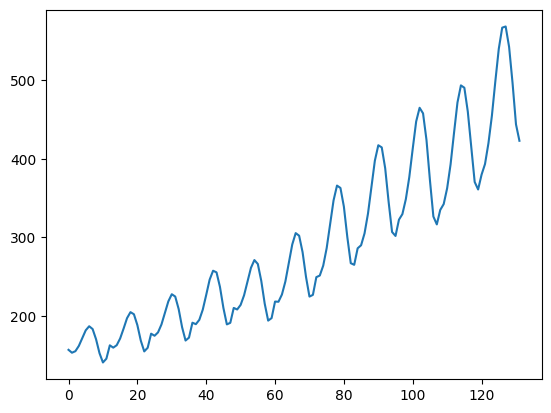

In [ ]:
plt.plot(np.array(output).squeeze())
plt.show()

In [194]:
class RNNCell(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size, bias=False) # Waa
        self.linear2 = nn.Linear(input_size, hidden_size, bias=True) # Wax + ba
        self.tanh = nn.Tanh()

        self.final = nn.Linear(hidden_size, output_size, bias=True) # Wya + by

    def forward(self, x, previous_a):
        aa = self.linear1(previous_a)
        ax = self.linear2(x)
        x = torch.add(aa, ax)
        a = self.tanh(x)
        x = self.final(a)
        return x, a

In [198]:
torch.set_grad_enabled(True)


initial_lr = 1e-5
layers = 3
cell = RNNCell(input_size=2) # passenger and the month index
optimizer = optim.Adam(cell.parameters(), lr=initial_lr)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, threshold=0.00005)
a0 = torch.zeros((64)).to(torch.float32)
c0 = torch.zeros((64)).to(torch.float32)
month_indexes = dataset.data.Month.apply(lambda x: int(x[-2:]))

EPOCH=500
sliding_window_length = 12

for ep in range(EPOCH):
    epoch_loss = 0
    for i in range(0, split-sliding_window_length):

        optimizer.zero_grad()
        passengers = torch.tensor(np.array(dataset.passengers[i:i+sliding_window_length])).to(torch.float32)
        months = torch.tensor(np.array(month_indexes[i:i+sliding_window_length])).to(torch.float32)
        prev_a = a0
        if len(passengers)<12:
            continue

        for p in range(sliding_window_length):
            input = torch.FloatTensor((months[p], passengers[p]))
            logit, a = cell(input, prev_a)
            prev_a= a

        target = torch.FloatTensor(dataset.passengers[i+sliding_window_length])
        loss = criterion(logit, target)
        loss.backward()
        optimizer.step()

        # print("Batch avg loss", batch_loss.item() / 4)
        epoch_loss += loss.item()

    print("EPOCH_LOSS", ep, epoch_loss / (split-sliding_window_length))
    scheduler.step(epoch_loss / (split-sliding_window_length))
    if initial_lr != optimizer.param_groups[0]['lr']:
        print(f"LR Changed {optimizer.param_groups[0]['lr']}")
        initial_lr = optimizer.param_groups[0]['lr']


EPOCH_LOSS 0 0.22154463422046894
EPOCH_LOSS 1 0.14146826034946156
EPOCH_LOSS 2 0.096368801813502
EPOCH_LOSS 3 0.07025096789018587
EPOCH_LOSS 4 0.05593075281630706
EPOCH_LOSS 5 0.048546799921620504
EPOCH_LOSS 6 0.044928918363019384
EPOCH_LOSS 7 0.04317640910677317
EPOCH_LOSS 8 0.04225370664756381
EPOCH_LOSS 9 0.04165115891442123
EPOCH_LOSS 10 0.04114518237969232
EPOCH_LOSS 11 0.04065215106662731
EPOCH_LOSS 12 0.04014936334832964
EPOCH_LOSS 13 0.03963695711121658
EPOCH_LOSS 14 0.039121433716587474
EPOCH_LOSS 15 0.038609245471135124
EPOCH_LOSS 16 0.03810531270013381
EPOCH_LOSS 17 0.03761265516181682
EPOCH_LOSS 18 0.037132817047926474
EPOCH_LOSS 19 0.036666386987010025
EPOCH_LOSS 20 0.03621327506760623
EPOCH_LOSS 21 0.035773050661572416
EPOCH_LOSS 22 0.03534498668482734
EPOCH_LOSS 23 0.03492834440597411
EPOCH_LOSS 24 0.034522263417341326
EPOCH_LOSS 25 0.034125958091062475
EPOCH_LOSS 26 0.03373864981391603
EPOCH_LOSS 27 0.033359539363623805
EPOCH_LOSS 28 0.03298801393036703
EPOCH_LOSS 29 0.

In [200]:
torch.set_grad_enabled(False)
try:
    output = []
    labels = []
    # input = torch.FloatTensor(test_loader.dataset)[i:i+sliding_window_length,1]
    for i in range(len(dataset.passengers) - sliding_window_length):
        passengers = torch.FloatTensor(dataset.passengers)[i:i+sliding_window_length]
        months = torch.FloatTensor(month_indexes)[i:i+sliding_window_length]
        
        prev_a = torch.zeros((64)).to(torch.float32)
        # logits, a_c_prev = cell(input, a_c_prev)
        for p in range(sliding_window_length):
            input = torch.FloatTensor((months[p], passengers[p]))
            logit, prev_a = cell(input, prev_a)
            
        output.append( dataset.scaler.inverse_transform(logit.reshape(-1, 1)))
        labels.append(dataset.scaler.inverse_transform(torch.FloatTensor(dataset.passengers)[sliding_window_length+i].reshape(-1, 1)))
    
    print(output)
    print(labels)

    toutput = torch.tensor(output)
    tlabels = torch.tensor(labels)
    # mape (mean absolute percentage error)
    # mean((actual-forecast) / actual)
    mape = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)) / torch.squeeze(tlabels))) # 0.1580, 0.1418(12-batch), 0.1343(sliding window), 0.1167(stacked lstm), 0.0730(stackedlstm with month)
    print(mape)

    # mae (mean absolute error)
    mae = torch.mean(torch.abs((torch.squeeze(toutput)-torch.squeeze(tlabels)))) # 82.5248, 71.5019, 69.0149, 35.3759, 20.0789
    print(mae)

    # rmse (root mean square error)
    rmse = torch.sqrt(torch.mean(torch.square((torch.squeeze(toutput)-torch.squeeze(tlabels))))) # 112.3071, 94.6528, 91.1919, 47.2027, 25.8126
    print(rmse)

finally:
    torch.set_grad_enabled(True)

[array([[158.62280507]]), array([[126.57203333]]), array([[144.01082052]]), array([[134.48662223]]), array([[121.63055696]]), array([[150.47571816]]), array([[157.8769836]]), array([[154.30711509]]), array([[151.96948378]]), array([[150.66313066]]), array([[147.99340563]]), array([[149.2534305]]), array([[169.52430385]]), array([[148.42136686]]), array([[172.20141578]]), array([[168.45384116]]), array([[157.04119949]]), array([[196.95142859]]), array([[198.61706877]]), array([[187.38562596]]), array([[179.38090461]]), array([[173.02867061]]), array([[168.34261324]]), array([[169.09336317]]), array([[186.39561248]]), array([[171.88517648]]), array([[204.55716509]]), array([[193.31335676]]), array([[181.5801301]]), array([[218.91072416]]), array([[231.0734095]]), array([[218.74782658]]), array([[212.85168111]]), array([[198.3284319]]), array([[190.25329965]]), array([[187.56924081]]), array([[203.66071892]]), array([[195.13933188]]), array([[229.08181977]]), array([[227.77728057]]), arra

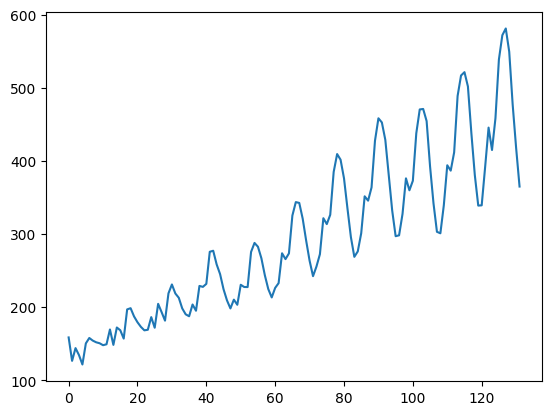

In [201]:
plt.plot(np.array(output).squeeze())
plt.show()